# Classical and quantum support vector machines

In this tutorial, we use Covalent to orchestrate a workflow that compares the perfomance of the SVM and QSVM models. We use the `scikit-learn` package for SVM and `qiskit_machine_learning` for QSVM implementations.

Covalent is responsible for: 

* constructing subtasks.

* constructing workflows, which, are comprised of subtasks.

* submitting the workflow for execution.

* polling the execution status of individual subtasks and the workflow.

* collecting the final results corresponding to the subtasks and the workflow.

First, we import all the packages related to plotting and constructing the SVM and QSVM models. `scikit-learn` is used to load a toy dataset for this tutorial.


In [7]:
# Import plotting library
import matplotlib.pyplot as plt

# Set global plot background color
plt.rcParams["figure.facecolor"] = "w"

# Import for SVM classifier
from sklearn.svm import SVC

# Imports for dataset and model selection
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Imports for QSVC classifier
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel

# Set the random seed for QSVC
seed = 12345
algorithm_globals.random_seed = seed


Next, we import `covalent` to construct and manage our workflows.

In [8]:
# Import workflow management library
import covalent as ct


The workflow is broken down into subtasks in order to compare the performance of SVM and QSVM. The list of subtasks are:

1. `get_data` - Retrieve a dataset commonly used for toy ML problems.

2. `split_train_test_data` - Split the data into training and test subsets.

3. `train_svc` - Train the SVC model with a classical linear kernel.

4. `train_qsvc` - Train the QSVC model with a quantum kernel using the `qiskit` library (more detailed tutorial [here](https://github.com/Qiskit/qiskit-machine-learning/blob/main/docs/tutorials/03_quantum_kernel.ipynb)).

The subtasks are constructed using the [ct.electron](../../api/api.rst#covalent.electron) decorator.

In [9]:
@ct.electron
def get_data():
    iris = datasets.load_iris()
    X = iris.data[:, :2]  # we only take the first two features.
    y = iris.target
    return X, y


@ct.electron
def split_train_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    return X_train, X_test, y_train, y_test


@ct.electron
def train_svc(X_train, y_train):
    svc = SVC(kernel="linear")
    svc.fit(X_train, y_train)
    return svc


@ct.electron
def train_qsvc(X_train, y_train):
    feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
    backend = QuantumInstance(
        BasicAer.get_backend("qasm_simulator"), shots=16, seed_simulator=seed, seed_transpiler=seed
    )
    kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
    qsvc = SVC(kernel=kernel.evaluate)
    qsvc.fit(X_train, y_train)
    return qsvc



Having constructed the subtasks, we can now construct the workflow using the [ct.lattice](../../api/api.rst#covalent.lattice) decorator.

In [10]:
@ct.lattice
def workflow():
    X, y = get_data()
    X_train, X_test, y_train, y_test = split_train_test_data(X=X, y=y)
    svc_model = train_svc(X_train=X_train, y_train=y_train)
    qsvc_model = train_qsvc(X_train=X_train, y_train=y_train)
    return X_test, y_test, svc_model, qsvc_model


.. note:: It is important to provide the argument names in the electron definitions. `train_svc(X_train, y_train)` will raise an error while `train_svc(X_train=X_train, y_train=y_train)` will not. Additionally, note that we should create electrons to perform subtasks rather than manipulating objects inside the lattice.

Next, we can visualize the workflow using the `draw` method. The visualization allows us to check if the workflow has been properly defined as well as retrieving the node ids corresponding to each subtasks.

.. tip:: The node ids are useful for retrieving the subtask execution details.

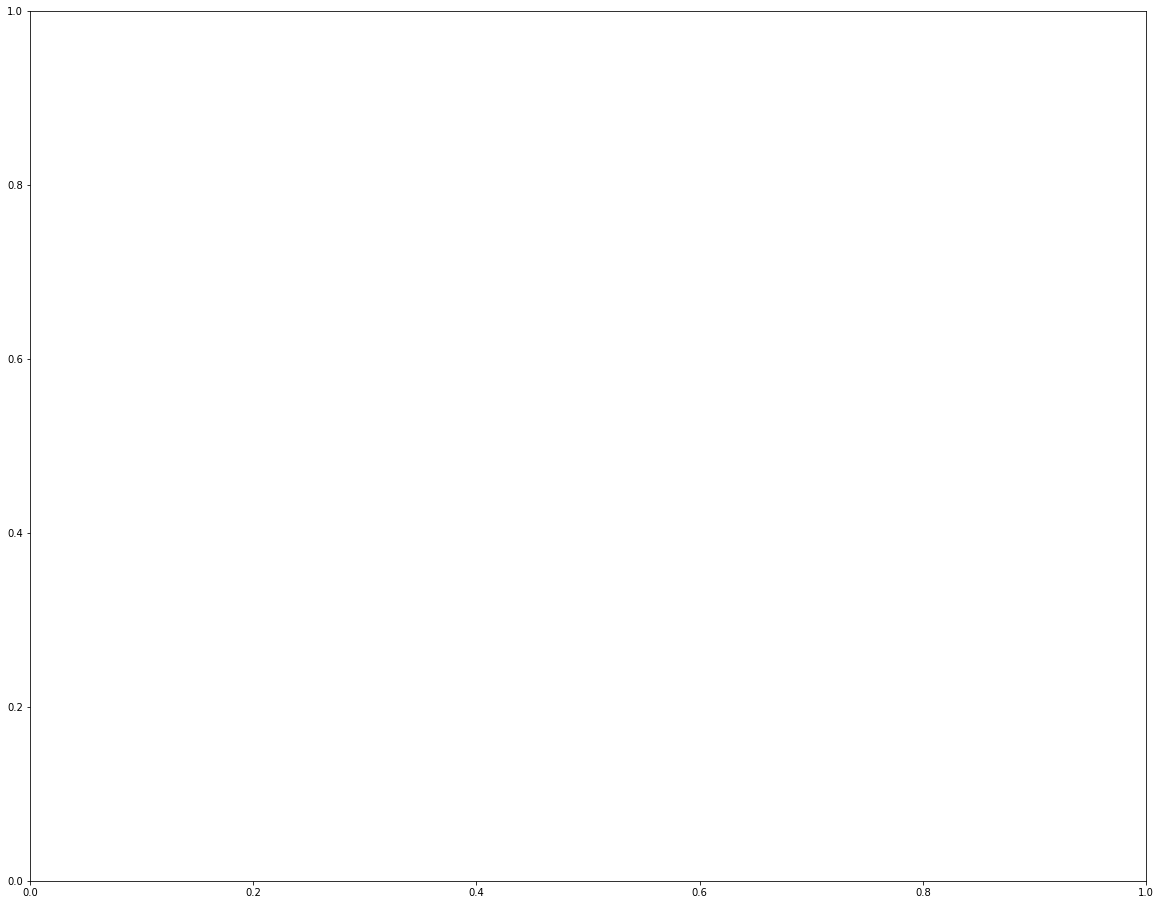

In [11]:
fig, ax = plt.subplots(figsize=(20, 16))

# It is important to include the parameter name and the value
workflow.draw(ax=ax)
plt.show()


Once we have ensured that the workflow has been constructed properly, we can submit the task via the `dispatch` method.

In [6]:
dispatch_id = ct.dispatch(workflow)()


The execution result can be retrieved using the `ct.get_result` method.

.. note:: If we set `wait=True`, the method will wait for all the subtasks to finish executing before retrieving the final result. Otherwise, the method will return a result object that can be queried for execution status using the `result.get_node_result(node_id)` method.

In [7]:
result = ct.get_result(dispatch_id=dispatch_id, wait=True)


In [8]:
X_test, y_test, svc_model, qsvc_model = result.result


Once the computations is completed, we can plot the confusion matrix for the models as shown below.

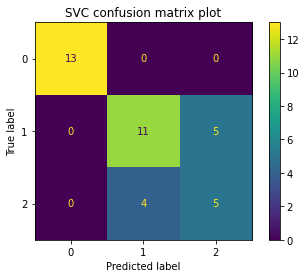

In [9]:
svc_cm_plot = ConfusionMatrixDisplay.from_estimator(svc_model, X_test, y_test);
svc_cm_plot.ax_.set_title("SVC confusion matrix plot");


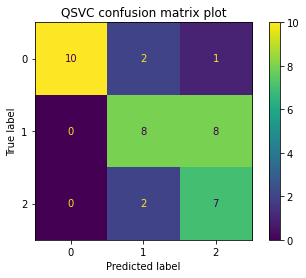

In [10]:
qsvc_cm_plot = ConfusionMatrixDisplay.from_estimator(qsvc_model, X_test, y_test);
qsvc_cm_plot.ax_.set_title("QSVC confusion matrix plot");


## Conclusion

In this tutorial, we used `covalent` to construct a workflow to compare the performance of SVM and QSVM models. Note that the SVM model training requires a classical hardware while the QSVM model training requires quantum hardware. A primary benefit of `covalent` is the convenience with which computational jobs can be submitted to either classical or quantum hardwares.